## FT7206 SEMINAR - LSTM
By the end of this activity, learners will be able to set up and apply LSTM in time series forecasting

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import eikon as ek

In [2]:
ek.set_app_key('4a3e5a3b0ff943d68f2a79e37cf828fe4354b99e')

In [3]:
df = ek.get_timeseries('SBRY.L',
                      fields = "*",
                      start_date = '2010-10-01',
                      end_date  = '2022-11-22')

In [4]:
df.head()

SBRY.L,HIGH,LOW,OPEN,CLOSE,COUNT,VOLUME
Date,,,,,,
2011-01-10,381.898775,374.66036,377.26619,375.721995,3012,3961190
2011-01-11,378.424336,374.370824,377.073165,376.783629,2821,4366974
2011-01-12,375.915019,367.035897,374.274312,368.676604,5396,10329280
2011-01-13,372.537092,366.234845,369.873355,368.194043,3659,5736071
2011-01-14,370.027775,363.928204,367.779041,366.456823,3191,3842092


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000 entries, 2011-01-10 to 2022-11-22
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    3000 non-null   Float64
 1   LOW     3000 non-null   Float64
 2   OPEN    3000 non-null   Float64
 3   CLOSE   3000 non-null   Float64
 4   COUNT   3000 non-null   Int64  
 5   VOLUME  3000 non-null   Int64  
dtypes: Float64(4), Int64(2)
memory usage: 181.6 KB


In [6]:
 cols = list(df)[1:6]

In [7]:
df_for_training = df[cols].astype(float)

In [8]:
df_for_training.head()

SBRY.L,LOW,OPEN,CLOSE,COUNT,VOLUME
Date,,,,,
2011-01-10,374.660360,377.266190,375.721995,3012.0,3961190.0
2011-01-11,374.370824,377.073165,376.783629,2821.0,4366974.0
2011-01-12,367.035897,374.274312,368.676604,5396.0,10329280.0
2011-01-13,366.234845,369.873355,368.194043,3659.0,5736071.0
2011-01-14,363.928204,367.779041,366.456823,3191.0,3842092.0


<AxesSubplot:xlabel='Date'>

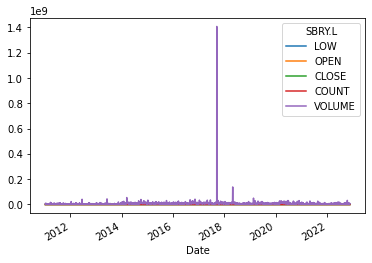

In [9]:
df_for_training.plot.line()

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [11]:
trainX = []
trainY = []
n_future = 1
n_past = 14

In [12]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i -n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i +n_future -1:i + n_future,0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (2986, 14, 5).
trainY shape == (2986, 1).


In [13]:
model = Sequential()
model.add(LSTM(64, activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
168/168 [==============================] - 3s 9ms/step - loss: 0.1064 - val_loss: 0.0236
Epoch 2/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0468 - val_loss: 0.0209
Epoch 3/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0430 - val_loss: 0.0155
Epoch 4/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0398 - val_loss: 0.0116
Epoch 5/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0381 - val_loss: 0.0130
Epoch 6/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0353 - val_loss: 0.0120
Epoch 7/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0352 - val_loss: 0.0102
Epoch 8/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0311 - val_loss: 0.0093
Epoch 9/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0301 - val_loss: 0.0077
Epoch 10/10
168/168 [==============================] - 1s 7ms/step - loss: 0.0308 - val_loss: 0.0106

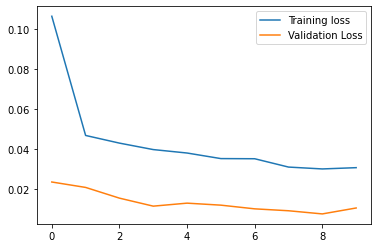

In [15]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [16]:
#n_past = 16
#n_days_for_prediction=15  #let us predict past 15 days

In [17]:
train_dates = pd.to_datetime(df.index)

In [18]:
n_future = 365 #redefined forecast period
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [19]:
forecast = model.predict(trainX[-n_future:])

12/12 [==============================] - 0s 3ms/step


In [20]:
forecast.shape

(365, 1)

Perform the inverse transformation to rescale back to original range.  
Remember 5 variables went into the original transformation?

In [21]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [22]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [23]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'OPEN':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='OPEN'>

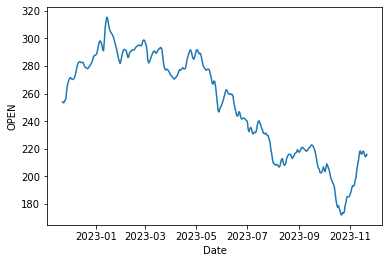

In [24]:
sns.lineplot(df_forecast['Date'],df_forecast['OPEN'])